<a href="https://colab.research.google.com/github/lukasdekanovsky/Become_PythonDeveloper_AI/blob/main/GAN_neuronov%C3%A9_s%C3%ADt%C4%9B_pro_u%C4%8Den%C3%AD_strojov%C3%A9ho_psan%C3%AD_%C4%8D%C3%ADslic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN neuronová síť pro strojové psaní číslic** Generativní síť kompetitivní


---



---



---



# Proti sobě stojící dvě neuronové sítě - DISKRIMINÁTOR a GENERÁTOR
# A) DISKRIMINÁTOR dostává výstup generátoru a vstup správných obrázků a říká 1 / 0 pravý nepravý obrázek - učí se zároveň
# B) GENERÁTOR má jako vstup náhodný šum a učení probíhá s cílem aby ho diskriminátor určil jako pravý obrázek


In [ ]:
# IMPORT všech podstatých balíčků
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import SGD, Adam
import sys, os

# Preprocessing Trénovacích dat pro DISKRIMINÁTOR


In [ ]:
# Nahrání testovacích a trénovacích balíčků
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Zobrazíme si jaký je náš formát dat v datové sadě
print(x_train[0])
#               = čísla 0-255, jeden pixel --> černobílé
print(y_train[0])

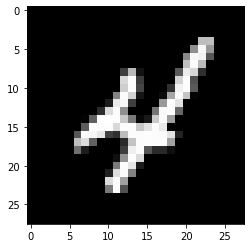

In [ ]:
# Vykreslíme si datový záznam na libovolné pozici
pixels = x_train[9]
plt.imshow(pixels, cmap="gray");

Datová normalizace

In [ ]:
# Provedeme normalizaci dat
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1


# výstup bude od -1 do 1


In [ ]:
# Ověříme si jak data vypadají
print(x_train[0])

Preprocessing

In [ ]:
N, H, W = x_train.shape
D = H * W

# znudlíme data
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [ ]:
# Zobrazení dat
x_train.shape

#           (60000, 784) 60 000 obrázků a délka znudlení 784 bodů

(60000, 784)

Zadefinujeme si dimenzionalitu latentního prostoru - náhodný šum = 1. hyperparametr

In [ ]:
latent_dim = 100

# Tvorba modelu neuronové sítě GENERÁTOR

In [ ]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x) #dropouts
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)


#   máme vstupní vrstvu (i) definovanou latent. dim = šum
#   poté 3 vrstvy x se vzrůstajícím počtem neuronů 256 -> 512 -> 1024 proložení BatchNormalization
#   vrstvy (x) mají alpha hyperparametr 0,2 učující náklon aktivační funkce LeakyReLU

    model = Model(i, x)
    return model

# Tvorba modelu neuronové sítě DISKRIMINÁTOR

In [ ]:
def build_discriminator(D):
    i = Input(shape=(D,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x) #pravý/falešný


#   Pro diskriminátor je vhodné opět snížit dimenzionalitu vrstev 1024 -> 512 -> 256 z toho se rozhoduje 1 neuron
#   Je nevhodné nechat vysokou dimenzi generátoru a nechat diskriminátor rozhodovat na základě vstupu ze všech
#   Uplatňuje se tzv. princip štrůdlu
    model = Model(i, x)
    return model

# KOMPILACE 1. - DISKRIMINÁTOR

In [ ]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# vyvoláme discriminator z funkce build_discriminator s parametrem (D - což je H*W)
# dodáme mu ztrátovou funkci, optimizer ...


# KOMPILACE 2. - GENERÁTOR

Zde je zapotřebí generátor zabalit ještě s okolím diskriminátoru aby vycházel z jeho dat - následující úpravou

In [ ]:
noise_input = Input(shape=(latent_dim,))

generator = build_generator(latent_dim)
fake_img = generator(noise_input)

discriminator.trainable = False   #tady si zastavíme na chvíli diskriminátor
fake_pred = discriminator(fake_img)

combined_model = Model(noise_input, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Nastavení trénovacího modelu

In [ ]:
batch_size = 32   # 32 dávek obrázků na dávku
epochs = 30000
sample_period = 200   # po 200 periodách nám to extrahuje ukázku výstupu

zeros = np.zeros(batch_size) #falesne obrazky (generovane generatorem) = ytrain
ones = np.ones(batch_size) #prave obrazky (mnist) = ytrain

d_losses = []
g_losses = []
d_acces = []

if not os.path.exists('gan_images'):   #vytvoří nám to adresář gen_images kde najdeme postupně výstupy programu
  os.makedirs('gan_images')

V jakém formátu chceme vidět výstupy dat - mřížka 5x5 obrázků

In [ ]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # přeškálování na 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

# Trénink diskriminátoru a generátoru

In [ ]:
for epoch in range(epochs):

    ###########################
    ### Train discriminator ###

    #prave obrazky
    idx = np.random.randint(0, N, batch_size)
    real_imgs = x_train[idx]

    #falesne obrazky
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
    ###########################



    #######################
    ### Train generator ###

    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    #######################

    d_losses.append(d_loss)
    g_losses.append(g_loss)
    d_acces.append(d_acc)

    if epoch % sample_period == 0:
        sample_images(epoch)
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")